<a href="https://colab.research.google.com/github/bundickm/DS-Unit-1-Sprint-1-Dealing-With-Data/blob/master/module4-databackedassertions/LS_DS_114_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [0]:
#y = "health level" - predicted variable, dependent variable
#x = "took the drug" - explanatory variable, independent variable

#some confounding variables: age, weight, height, gender, medical history, genetics, socioeconomic conditions, dosage, severity of illness, etc.
#omitted variables == confounding variables

In [0]:
import random
random.seed(42)
#dir(random)  # Reminding ourselves what we can do here

In [40]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [41]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something

users = []

#create desktop users
for _ in range(250):
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
#create mobile users
for _ in range(750):
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=False, time_on_site=150.42273427770718, mobile=False), User(purchased=True, time_on_site=284.06235530493245, mobile=True), User(purchased=True, time_on_site=140.37976895454653, mobile=True), User(purchased=True, time_on_site=49.206452507812216, mobile=True), User(purchased=False, time_on_site=167.81563803588924, mobile=True), User(purchased=False, time_on_site=20.484876517641524, mobile=True), User(purchased=False, time_on_site=167.3540069049869, mobile=True), User(purchased=False, time_on_site=447.75054592529114, mobile=False), User(purchased=True, time_on_site=57.93525538719398, mobile=True), User(purchased=True, time_on_site=292.6494305470663, mobile=True)]


In [42]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,False,150.422734,False
1,True,284.062355,True
2,True,140.379769,True
3,True,49.206453,True
4,False,167.815638,True


In [45]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.789338167851291,5.836487686604824,7.267690340465448,7.280322437947023,7.733814701629437,7.772242279186957,7.994578759409748,8.373541587279558,9.106003254765849,9.38379653305911,...,582.5363605031145,582.9362427920347,588.8783154469735,590.65747470592,593.8187768755912,597.1381204299279,597.7116143416571,598.547187832115,599.088120104121,599.5766563635087
purchased,,,,,,,,,,,,,,,,,,,,,
False,1,1,0,1,1,1,1,1,1,1,...,0,1,1,0,1,1,1,1,1,1
True,0,0,1,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0


In [46]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(5.196, 124.547]","(124.547, 243.304]","(243.304, 362.062]","(362.062, 480.819]","(480.819, 599.577]"
purchased,,,,,
False,227,238,111,23,37
True,106,133,84,20,21


In [47]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(5.196, 124.547]","(124.547, 243.304]","(243.304, 362.062]","(362.062, 480.819]","(480.819, 599.577]"
purchased,,,,,
False,0.681682,0.641509,0.569231,0.534884,0.637931
True,0.318318,0.358491,0.430769,0.465116,0.362069


In [48]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.704,0.613333
True,0.296,0.386667


In [0]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

In [55]:
pd.crosstab(user_data['mobile'], [user_data['purchased'], time_bins], 
            rownames=['device'], colnames=['purchased', 'time on site'], 
            normalize='index')

purchased               False                                        \
time on site (5.196, 124.547] (124.547, 243.304] (243.304, 362.062]   
device                                                                
False                0.148000              0.172              0.144   
True                 0.253333              0.260              0.100   

purchased                                                     True   \
time on site (362.062, 480.819] (480.819, 599.577] (5.196, 124.547]   
device                                                                
False                     0.092              0.148            0.016   
True                      0.000              0.000            0.136   

purchased                                                              \
time on site (124.547, 243.304] (243.304, 362.062] (362.062, 480.819]   
device                                                                  
False                  0.044000              0.072               0.08   
True                   0.162667              0.088               0.00   

purchased                        
time on site (480.819, 599.577]  
device                           
False                     0.084  
True                      0.000

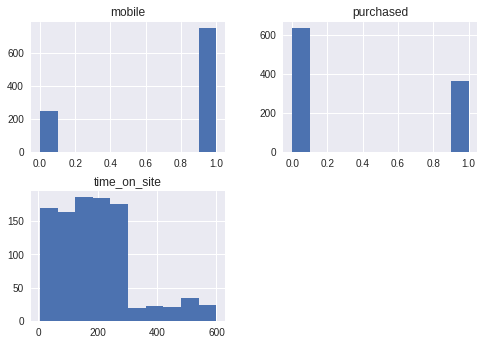

In [61]:
user_data.hist(bins=10);

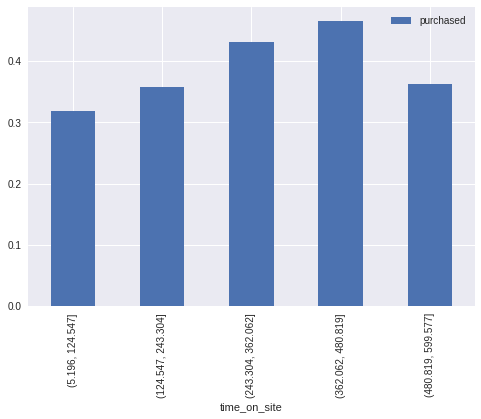

In [63]:
pd.pivot_table(user_data, values='purchased',index=time_bins).plot.bar()

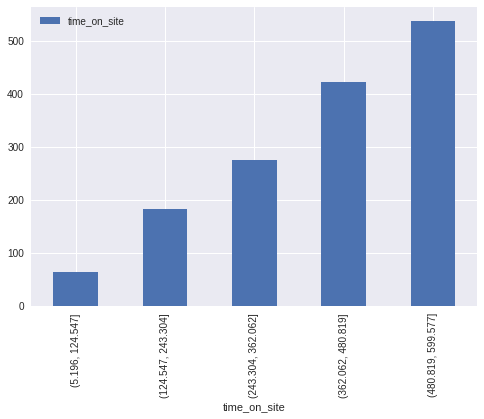

In [64]:
pd.pivot_table(user_data, values='time_on_site',index=time_bins).plot.bar()

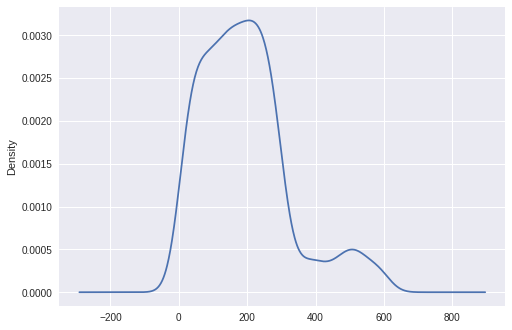

In [62]:
user_data['time_on_site'].plot.density()

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [0]:
# TODO - your code here
# Use what we did live in lecture as an example

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself

In [0]:
#import and alias
import pandas as pd
import matplotlib.pyplot as plt

In [67]:
#read in and check the csv
persons = pd.read_csv('https://raw.githubusercontent.com/bundickm/DS-Unit-1-Sprint-1-Dealing-With-Data/master/module4-databackedassertions/persons.csv')
persons.head()

,Unnamed: 0,age,weight,exercise_time
0,0,44,118,192
1,1,41,161,35
2,2,46,128,220
3,3,39,216,57
4,4,28,116,182


In [68]:
#unnamed:0 appears to be the index, so drop it as the df has one
persons.columns = ['ID','age','weight','exercise(t)']
persons = persons.set_index('ID')
persons.head()

,age,weight,exercise(t)
ID,,,
0,44,118,192
1,41,161,35
2,46,128,220
3,39,216,57
4,28,116,182


In [69]:
persons.dtypes

age            int64
weight         int64
exercise(t)    int64
dtype: object

In [70]:
persons.isnull().sum()

age            0
weight         0
exercise(t)    0
dtype: int64

In [71]:
persons.shape

(1200, 3)

In [87]:
exercise_bins = pd.cut(persons['exercise(t)'], 5)
weight_bins = pd.cut(persons['weight'],10)
pd.crosstab(weight_bins, exercise_bins, normalize='columns')

exercise(t),"(-0.3, 60.0]","(60.0, 120.0]","(120.0, 180.0]","(180.0, 240.0]","(240.0, 300.0]"
weight,,,,,
"(99.854, 114.6]",0.097122,0.088608,0.183857,0.197917,0.235602
"(114.6, 129.2]",0.093525,0.117089,0.134529,0.213542,0.324607
"(129.2, 143.8]",0.075540,0.101266,0.143498,0.203125,0.219895
"(143.8, 158.4]",0.082734,0.139241,0.156951,0.182292,0.167539
"(158.4, 173.0]",0.111511,0.148734,0.125561,0.130208,0.052356
"(173.0, 187.6]",0.107914,0.145570,0.125561,0.067708,0.000000
"(187.6, 202.2]",0.107914,0.098101,0.121076,0.005208,0.000000
"(202.2, 216.8]",0.165468,0.132911,0.008969,0.000000,0.000000
"(216.8, 231.4]",0.100719,0.028481,0.000000,0.000000,0.000000


In [73]:
age_bins = pd.cut(persons['age'],10)
pd.crosstab(weight_bins, age_bins, normalize='columns')

age,"(17.938, 24.2]","(24.2, 30.4]","(30.4, 36.6]","(36.6, 42.8]","(42.8, 49.0]","(49.0, 55.2]","(55.2, 61.4]","(61.4, 67.6]","(67.6, 73.8]","(73.8, 80.0]"
weight,,,,,,,,,,
"(99.854, 114.6]",0.140741,0.190083,0.146154,0.219512,0.119658,0.188679,0.115044,0.091743,0.152672,0.121739
"(114.6, 129.2]",0.162963,0.132231,0.246154,0.211382,0.179487,0.216981,0.168142,0.100917,0.106870,0.104348
"(129.2, 143.8]",0.148148,0.173554,0.100000,0.130081,0.205128,0.103774,0.141593,0.174312,0.099237,0.113043
"(143.8, 158.4]",0.162963,0.190083,0.123077,0.138211,0.102564,0.141509,0.168142,0.155963,0.114504,0.113043
"(158.4, 173.0]",0.140741,0.107438,0.123077,0.065041,0.145299,0.094340,0.097345,0.100917,0.167939,0.121739
"(173.0, 187.6]",0.074074,0.057851,0.100000,0.097561,0.085470,0.113208,0.123894,0.082569,0.114504,0.130435
"(187.6, 202.2]",0.096296,0.033058,0.038462,0.048780,0.051282,0.047170,0.088496,0.146789,0.091603,0.104348
"(202.2, 216.8]",0.044444,0.090909,0.084615,0.073171,0.059829,0.075472,0.088496,0.073394,0.076336,0.086957
"(216.8, 231.4]",0.007407,0.024793,0.038462,0.008130,0.025641,0.009434,0.008850,0.036697,0.068702,0.078261


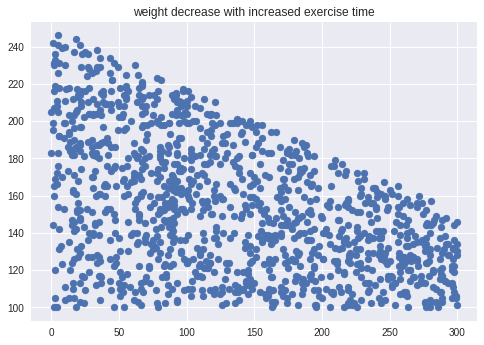

In [102]:
plt.scatter(persons['exercise(t)'],persons['weight'])
plt.title('weight decreases with increased exercise time')
plt.show()

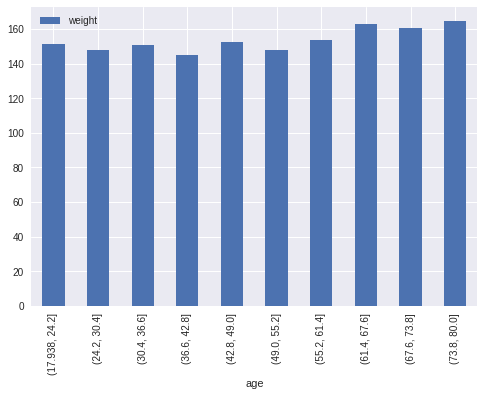

In [95]:
#weight per age group
pd.pivot_table(persons, values='weight',index='age').plot.bar()

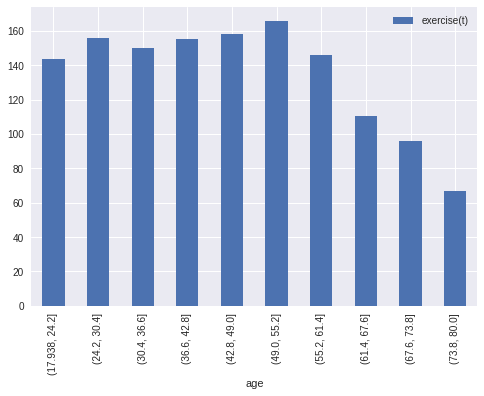

In [93]:
#level of exercise per age group
pd.pivot_table(persons, values='exercise(t)',index=age_bins).plot.bar()

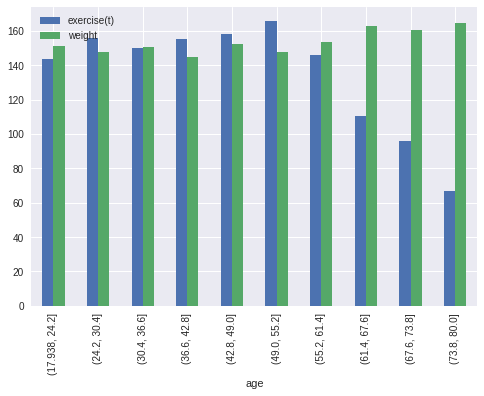

In [103]:
#exercise and weight for age groups
pd.pivot_table(persons, values=['exercise(t)', 'weight'],index=age_bins).plot.bar()

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?
2.  What are the relationships between the variables?
3.  Which relationships are "real", and which spurious?


#1.  What are the variable types in the data?


*   ID (int64): Discrete, just an index stepping by 1
*   Age (int64): Discrete - binned by year. Age could be continous but is not so in this dataset
*   Weight (int64): Discrete - binned by pounds. Just like age, could be continous but is not so in this dataset
*   Exercise Time (int64): - Discrete - binned by minutes. Same as the other two. Could be continous but is not being treated as such in this dataset



#2.  What are the relationships between the variables?

ID to:
*   All: ID has no correlation, simply an index. ID steps by 1 and is independent of the other variables

Age to:
*   Weight: slight increase in weight as age increases, this is likely just a result of excercise time decreasing with age. We can strengthen that assumption by noting that weight starts its upward trend right around where exercise begins decreasing with age.
*   Exercise Time: Exercise time decreases with age starting around 50ish years of age

Weight to:
*   Exercise Time: Weight decreases as exercise time increases. This is the main causal link with age having an indirect impact through exercise time

#3.  Which relationships are "real", and which spurious?
Real: Weight v Exercise Time, and Exercise Time v Age
Spurious: Weight v Age thanks to the third variable exercise time 


## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)